Importing Libraries

In [31]:
# For data
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

# Train, test, validation splits

from sklearn.model_selection import TimeSeriesSplit


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose 

Reading in CSV/Data Cleaning

In [2]:
df = pd.read_csv("ad_viz_plotval_data.csv")
df.head(5)

,Date,Source,Site ID,POC,Daily Mean PM10 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2021,AQS,60070008,3,24,ug/m3 SC,22,Chico-East Avenue,1,100.0,81102,PM10 Total 0-10um STP,17020.0,"Chico, CA",6,California,7,Butte,39.76168,-121.84047
1,01/02/2021,AQS,60070008,3,21,ug/m3 SC,19,Chico-East Avenue,1,100.0,81102,PM10 Total 0-10um STP,17020.0,"Chico, CA",6,California,7,Butte,39.76168,-121.84047
2,01/03/2021,AQS,60070008,3,19,ug/m3 SC,18,Chico-East Avenue,1,100.0,81102,PM10 Total 0-10um STP,17020.0,"Chico, CA",6,California,7,Butte,39.76168,-121.84047
3,01/04/2021,AQS,60070008,3,10,ug/m3 SC,9,Chico-East Avenue,1,100.0,81102,PM10 Total 0-10um STP,17020.0,"Chico, CA",6,California,7,Butte,39.76168,-121.84047
4,01/05/2021,AQS,60070008,3,12,ug/m3 SC,11,Chico-East Avenue,1,100.0,81102,PM10 Total 0-10um STP,17020.0,"Chico, CA",6,California,7,Butte,39.76168,-121.84047


In [3]:
df.dtypes

Date                              object
Source                            object
Site ID                            int64
POC                                int64
Daily Mean PM10 Concentration      int64
UNITS                             object
DAILY_AQI_VALUE                    int64
Site Name                         object
DAILY_OBS_COUNT                    int64
PERCENT_COMPLETE                 float64
AQS_PARAMETER_CODE                 int64
AQS_PARAMETER_DESC                object
CBSA_CODE                        float64
CBSA_NAME                         object
STATE_CODE                         int64
STATE                             object
COUNTY_CODE                        int64
COUNTY                            object
SITE_LATITUDE                    float64
SITE_LONGITUDE                   float64
dtype: object

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
#new data frame with only relevant data

df_PM10 = df[["Date", "Daily Mean PM10 Concentration"]]
df_PM10 = df_PM10.groupby(df_PM10["Date"])["Daily Mean PM10 Concentration"].sum()
df_PM10.head()

Date
2021-01-01    1454
2021-01-02    1533
2021-01-03    1578
2021-01-04    2474
2021-01-05    1479
Name: Daily Mean PM10 Concentration, dtype: int64

In [6]:
# drop null values
df_PM10.dropna()

Date
2021-01-01    1454
2021-01-02    1533
2021-01-03    1578
2021-01-04    2474
2021-01-05    1479
              ... 
2021-12-27     779
2021-12-28     595
2021-12-29     529
2021-12-30     924
2021-12-31    1078
Name: Daily Mean PM10 Concentration, Length: 365, dtype: int64

EDA

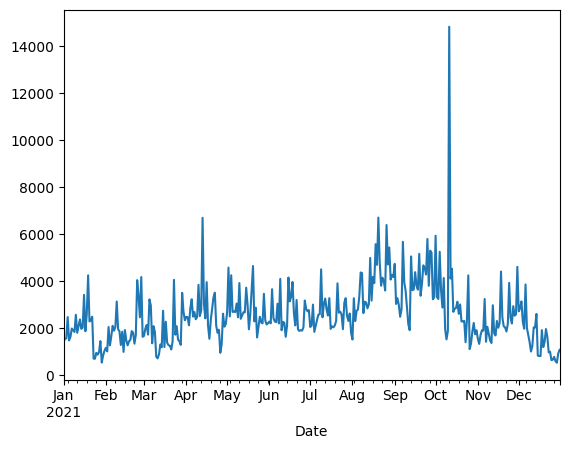

<Figure size 3000x2500 with 0 Axes>

In [11]:
df_PM10.plot()

figure(figsize=(30, 25), dpi=100)

plt.show()

In [13]:
#Multiplicate decomposition
dec_mul = seasonal_decompose(df_PM10, model = 'multiplicative', extrapolate_trend='freq')

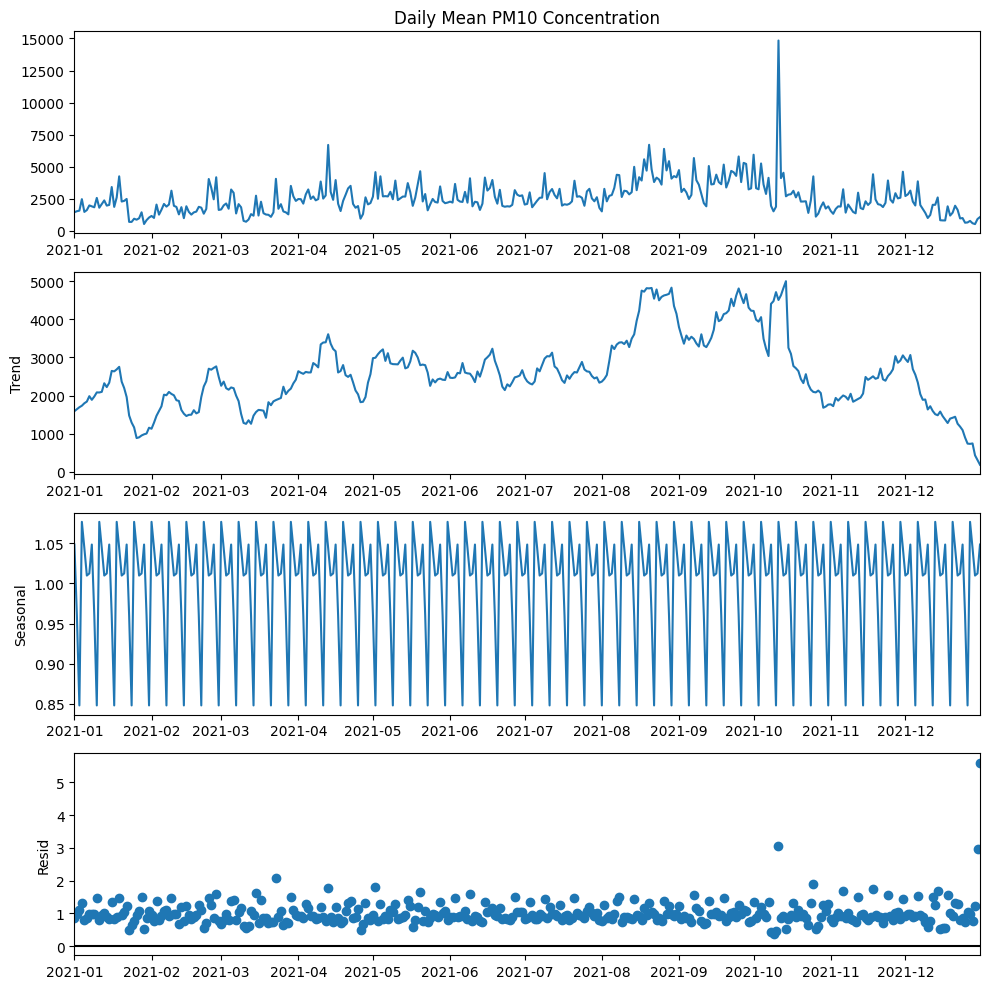

In [23]:
dec_mul.plot()
plt.rcParams.update({'figure.figsize': (10,10)})
plt.show()


In [18]:
#Additive decomposition
dec_add = seasonal_decompose(df_PM10, model = 'additive', extrapolate_trend='freq')

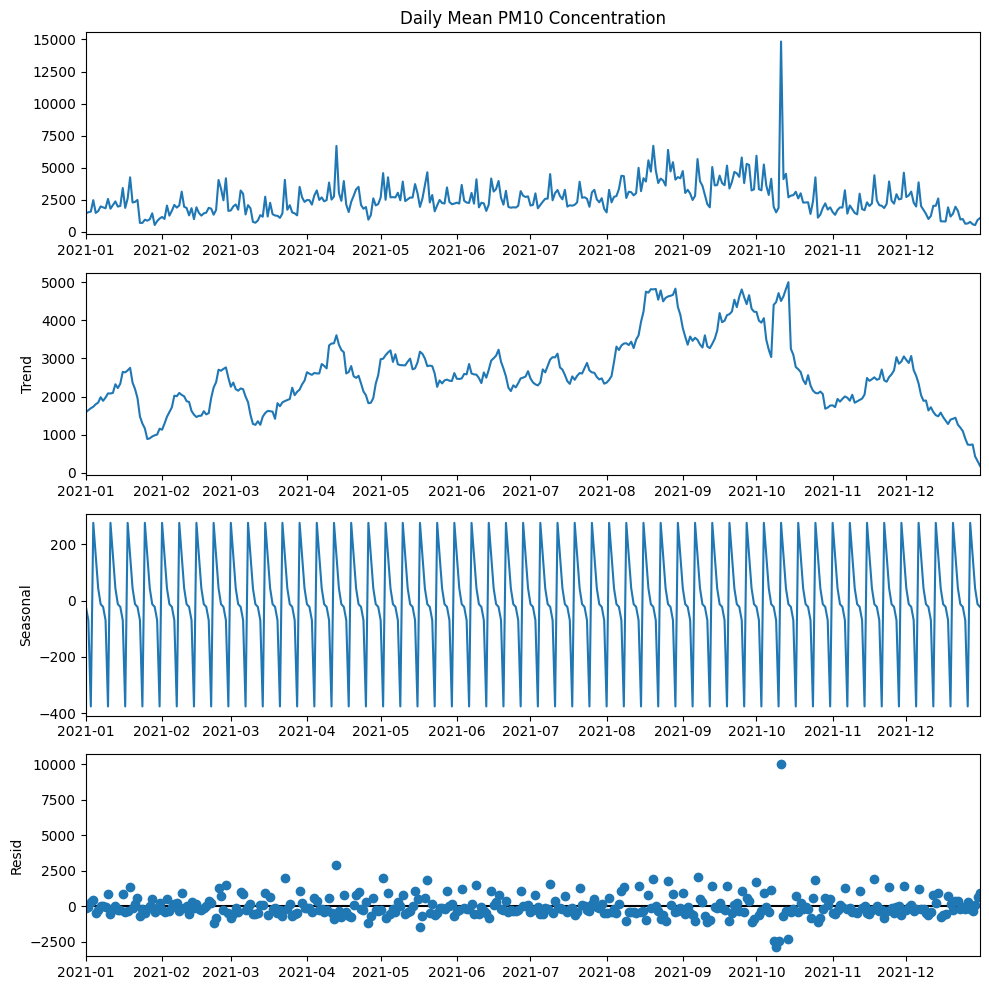

In [27]:
dec_add.plot()
plt.rcParams.update({'figure.figsize': (10,10)})

plt.show()

In [32]:
#ADF test
result = adfuller(df_PM10.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.6545815280952993
p-value: 0.4546521307906879
Critial Values:
   1%, -3.449336554273722
Critial Values:
   5%, -2.8699055166063085
Critial Values:
   10%, -2.571226758215748


In [33]:
# KPSS Test
result = kpss(df_PM10.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.666982
p-value: 0.016547
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


Checking Stationarity/Differencing

Model Building